In [1]:
import numpy as np
import sympy as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import trange

## Implémentation d'un modèle de régression logistiaue avec Numpy

### 1 Régression logistique et applications

#### 1.1 Régression logistique

##### 1.1.1 Inférence

In [2]:
def inference(X, theta):
    return (X @ theta) > 0

##### 1.1.2 Sigmoïde

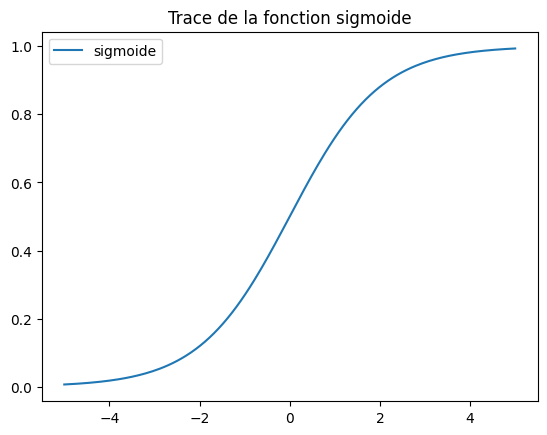

In [3]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def graph_sigmoide():
    x = np.linspace(-5, 5, num=200)
    y = sigmoide(x)
    plt.plot(x,y, label='sigmoide')
    plt.legend()
    plt.title('Trace de la fonction sigmoide')
    
graph_sigmoide()

##### 1.1.3 Fonction de perte

La fonction de perte est:
$$ H(\mathbb{P},\mathbb{Q}) = - \sum_{x \in \mathbb{X}}\mathbb{P}(x)log(\mathbb{Q}(x)) $$

$$ H(\mathbb{P},\mathbb{Q}) = -plog(q) -(1-p)log(1-q)$$
où $$ \mathbb{X} = \{0, 1\}, \quad p = \mathbb{P}(X = 1), \quad q = \mathbb{Q}(X = 1) $$ 

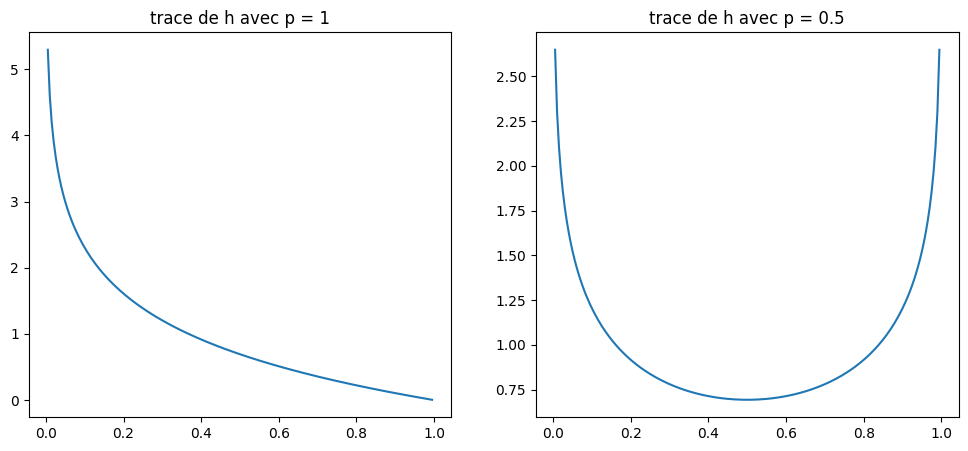

In [4]:
def h(p,q):
    return -p*np.log(q) - (1-p)*np.log(1 - q)

def graphe_h(p = (1.0, 0.5)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    q = np.linspace(0, 1, 200)[1:-1]
    axes[0].plot(q, h(p[0], q))
    axes[0].set_title('trace de h avec p = 1')
    axes[1].plot(q, h(p[1],q))
    axes[1].set_title('trace de h avec p = 0.5')
    return q, axes
graphe_h()
print('\n')

D'apres les graphes on suppose que:
- $ \mathbb{H} $ atteint son minimum en $ q = 1 $ lorsque $ p = 1 $
- $ \mathbb{H} $ atteint son minimum en $ q = 0.5 $ lorsque $ p = 0.5 $

##### 1.1.4 Dérivée

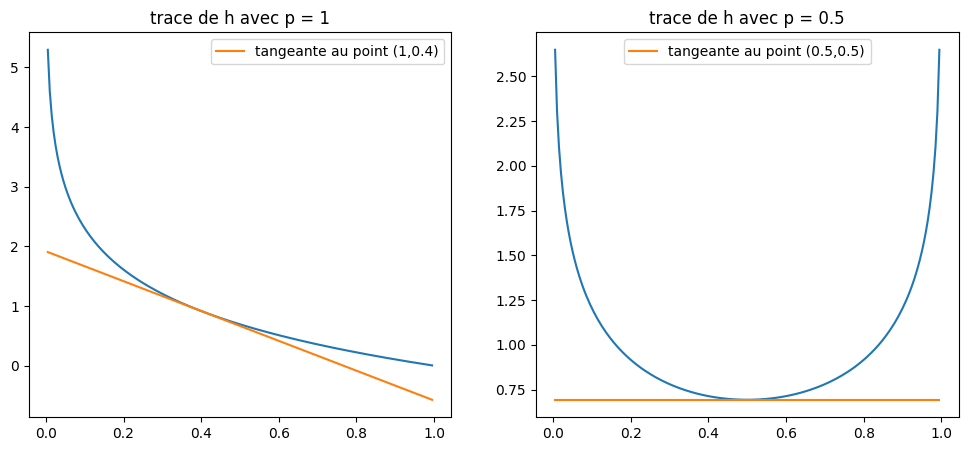

In [5]:
# calcul de la fonction dérivée de h par q avec sympy
def sm_diff_h_q():
    p, q = sm.symbols('p, q')
    h = -p*sm.log(q) - (1-p)*sm.log(1 - q)
    expr = sm.diff(h, q)
    return sm.lambdify((p,q), expr, 'numpy')

diff_h_q =  sm_diff_h_q()

def graphe_tangeante(p0 = 1,p1 = 0.5, q0 = 0.4, q1 = 0.5):
    q, axes = graphe_h((p0,p1))
    axes[0].plot(q, h(p0,q0) + diff_h_q(p0,q0)*(q - q0),
                 label=f'tangeante au point ({p0},{q0})')
    axes[1].plot(q, h(p1,q1) + diff_h_q(p1,q1)*(q - q1),
                 label=f'tangeante au point ({p1},{q1})')
    axes[0].legend()
    axes[1].legend()

graphe_tangeante()

##### 1.1.5 Gradient

In [6]:
def gradient(X: np.ndarray, theta: np.ndarray, p: np.ndarray):
    return (1/X.shape[0]) * X.T @ (sigmoide(X @ theta) - p)

##### 1.1.6 Entraînement

In [7]:
def entrainement(X, p, alpha=0.1, iter=1000):
    theta = np.random.normal(size=(X.shape[1], ))
    for i in trange(iter):
        theta = theta - alpha*gradient(X, theta, p)
    return theta    

##### 1.1.7 Classification Iris

In [8]:
# 1)
data = np.loadtxt('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', delimiter=',', dtype='O')
data[:,-1][data[:,-1] == 'Iris-setosa'] = 'setosa'; 
data[:,-1][data[:,-1] == 'Iris-versicolor'] = 'versicolor'; 
data[:,-1][data[:,-1] == 'Iris-virginica'] = 'virginica'; 
data[0:5,:]

array([['5.1', '3.5', '1.4', '0.2', 'setosa'],
       ['4.9', '3.0', '1.4', '0.2', 'setosa'],
       ['4.7', '3.2', '1.3', '0.2', 'setosa'],
       ['4.6', '3.1', '1.5', '0.2', 'setosa'],
       ['5.0', '3.6', '1.4', '0.2', 'setosa']], dtype=object)

In [9]:
#2)
def get_X(cols):
    return data.copy()[:, cols].astype(float)

def get_binary_targets(flower):
    return (data[:, -1] != flower).astype(int)

In [10]:
#3)
X = get_X([0,1])
p = get_binary_targets('setosa')
theta = entrainement(X,p, alpha=0.1, iter=10000)


100%|██████████| 10000/10000 [00:00<00:00, 23632.53it/s]


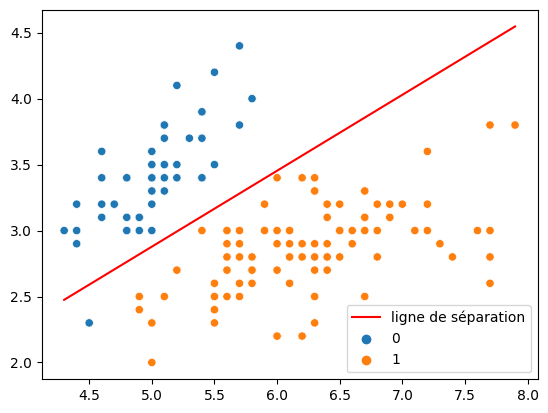

In [11]:
#4) #5)
def separation_line(x, theta):
    return - (theta[0]/theta[1])*x

def plot_regression(X, p, theta):
    x = np.linspace(X[:,0].min(),X[:,0].max(), num=200)
    sns.scatterplot(x=X[:,0],y=X[:,1], hue=p)
    y = separation_line(x, theta)
    plt.plot(x,y, color='r', label="ligne de séparation")
    plt.legend()
    
plot_regression(X,p,theta)

##### 1.1.8 Probabilité Iris

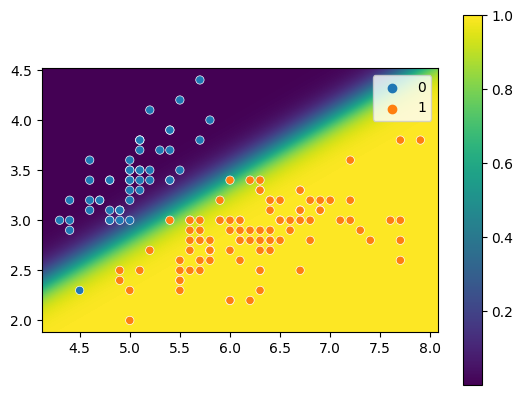

In [12]:
proba = lambda x,y, theta: sigmoide(x*theta[0] + y*theta[1])

def plot_regression_proba(
    X: np.ndarray,p: np.ndarray, 
    theta = None, max_iter=10000,
    probafunc=proba):
    coef = entrainement(X, p, iter=max_iter) if theta is None else theta
    x_length = np.max(X[:,0]) - np.min(X[:,0])     
    y_length = np.max(X[:,1]) - np.min(X[:,1])     
    x_bornes = (np.min(X[:,0]) - 0.05*x_length, np.max(X[:,0]) + 0.05*x_length)
    y_bornes = (np.min(X[:,1]) - 0.05*y_length, np.max(X[:,1]) + 0.05*y_length)
    x_axis = np.linspace(*x_bornes, num=500)
    y_axis = np.linspace(*y_bornes, num=500)
    grid_x, grid_y = np.meshgrid(x_axis, y_axis)
    plt.imshow(probafunc(grid_x,grid_y,coef), origin='lower', extent=(*x_bornes, *y_bornes))
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=p)
    plt.colorbar()
    
plot_regression_proba(X,p,theta)

##### 1.1.9 Intercept

100%|██████████| 10000/10000 [00:00<00:00, 44642.53it/s]


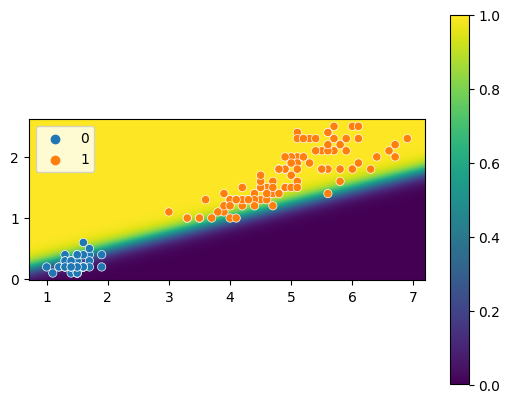

In [13]:
plot_regression_proba(
    get_X([2,3]), get_binary_targets('setosa'))

On peut clairement voir un probleme de Fit

In [14]:
def get_X_for_intercept(cols):
    X = get_X(cols)
    return np.concatenate((X, np.ones((X.shape[0], 1))),  axis=1)

def proba_with_intercept(x,y,theta):
    return sigmoide(x*theta[0] + y*theta[1] + theta[2])


100%|██████████| 10000/10000 [00:00<00:00, 31783.77it/s]


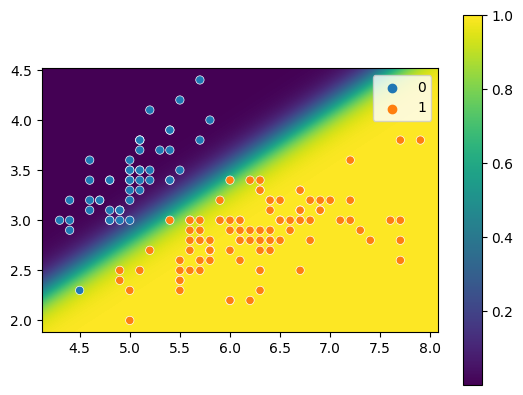

In [15]:
plot_regression_proba(get_X_for_intercept([0,1]), get_binary_targets('setosa'), probafunc=proba_with_intercept)

Le fit est similaire avec ou sans intercept pour les 2 premieres colonnes

100%|██████████| 10000/10000 [00:00<00:00, 47205.24it/s]


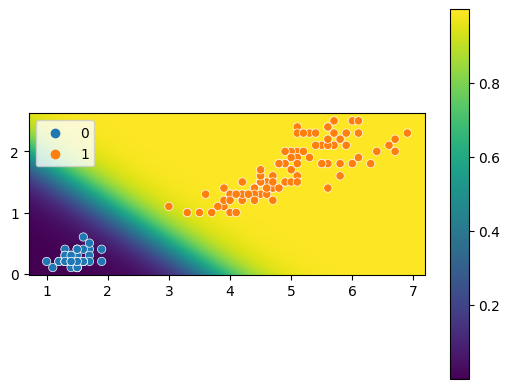

In [16]:
plot_regression_proba(get_X_for_intercept([2,3]), get_binary_targets('setosa'), probafunc=proba_with_intercept)

Le fit est nettement ameliore avec l'intercept pour les deux dernieres colonnes

##### 1.1.10 Plusieurs classes

In [17]:
#1)
def sigmoide_i(z:np.ndarray):
    return(np.exp(z)/(np.exp(z).sum()))
    
def monsoftmax(z: np.ndarray):
    return np.apply_along_axis(func1d=sigmoide_i, axis=1, arr=z) 

monsoftmax(np.array([[1.4,0.5],[2.8,1.9]]))

array([[0.7109495, 0.2890505],
       [0.7109495, 0.2890505]])

In [18]:
#2)
from scipy.special import softmax
softmax([[1.4,0.5],[2.8,1.9]],axis=1)

array([[0.7109495, 0.2890505],
       [0.7109495, 0.2890505]])

In [19]:
#3)
def gradient_k(X: np.ndarray, theta: np.ndarray, p: np.ndarray):
    return (1/X.shape[0]) * (X.T @ (softmax(X @ theta, axis=1) - p))

In [20]:
#4)
def entrainement_k(X, p, alpha=0.1, iter=1000):
    theta = np.random.normal(size=(X.shape[1], 3))
    for i in trange(iter):
        theta = theta - alpha*gradient_k(X, theta, p)
    return theta

In [21]:
#5)
def get_p_iris(data: np.ndarray = data):
    return pd.get_dummies(data[:,-1]).to_numpy()

get_p_iris()[:5,:]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [22]:
#6)
entrainement_k(get_X([1,2]), get_p_iris())

100%|██████████| 1000/1000 [00:00<00:00, 5882.97it/s]


array([[ 2.76278306,  0.44869165, -3.21145794],
       [-3.10031848, -0.5389419 ,  1.65557341]])

In [23]:
#7) #8)

def logit_proba_func(grid_x, grid_y, coef, i):
    return grid_x*coef[0,i] + grid_y*coef[1,i]

def plot_proba_multidim(X, p, theta = None,
                        probafunc=logit_proba_func,max_iter=10000):
    coef = entrainement_k(X, p, iter=max_iter) if theta is None else theta
    x_length = np.max(X[:,0]) - np.min(X[:,0])     
    y_length = np.max(X[:,1]) - np.min(X[:,1])     
    x_bornes = (np.min(X[:,0]) - 0.05*x_length, np.max(X[:,0]) + 0.05*x_length)
    y_bornes = (np.min(X[:,1]) - 0.05*y_length, np.max(X[:,1]) + 0.05*y_length)
    x_axis = np.linspace(*x_bornes, num=500)
    y_axis = np.linspace(*y_bornes, num=500)
    grid_x, grid_y = np.meshgrid(x_axis, y_axis)    
    logits = np.zeros((500,500,coef.shape[1])) #type: ignore
    for i in range(coef.shape[1]): #type: ignore
        logits[:,:,i]= probafunc(grid_x, grid_y, coef, i) #type: ignore

    image = softmax(logits, axis=coef.shape[1]-1) #type: ignore
    plt.imshow(image, origin='lower', extent=(*x_bornes, *y_bornes))
    sns.scatterplot(data=X, x=X[:,0], y=X[:,1], hue=data[:,-1],  edgecolor='black',
                linewidth=1, palette=['r','g','b'])
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


100%|██████████| 10000/10000 [00:01<00:00, 6174.47it/s]


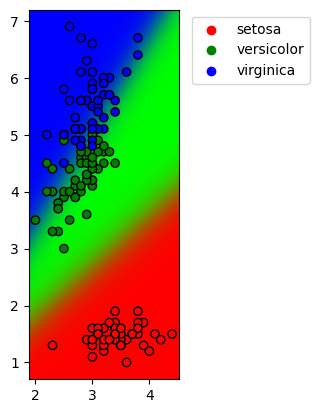

In [24]:
plot_proba_multidim(get_X([1,2]), get_p_iris())

##### 1.1.11 Plusieurs classes, amélioré

In [25]:
def logit_proba_func_for_intercept(grid_x, grid_y, coef, i):
    return grid_x*coef[0,i] + grid_y*coef[1,i] + coef[2,i]

Test du Multidim avec intercept pour les colonnes 2 et 3

100%|██████████| 10000/10000 [00:01<00:00, 7141.57it/s]


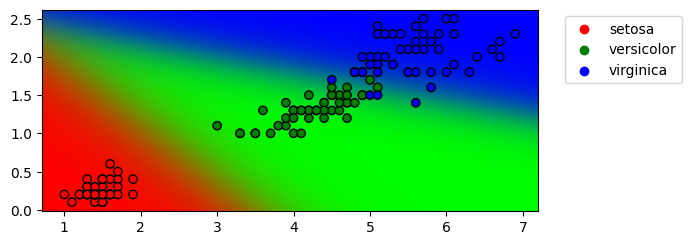

In [26]:
plot_proba_multidim(get_X_for_intercept([2,3]), get_p_iris(),
                    probafunc=logit_proba_func_for_intercept)

Test du Multidim avec intercept pour les colonnes 1 et 3

100%|██████████| 10000/10000 [00:01<00:00, 9433.82it/s]


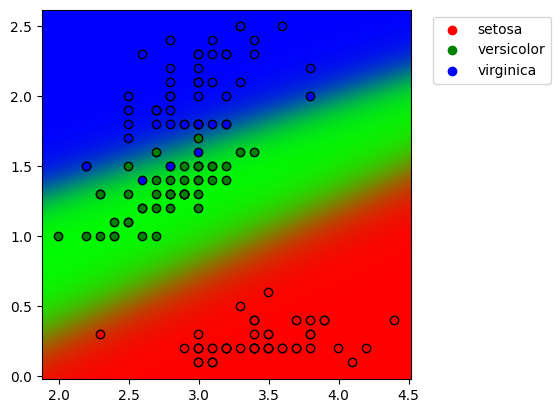

In [27]:
plot_proba_multidim(get_X_for_intercept([1,3]), get_p_iris(),
                    probafunc=logit_proba_func_for_intercept)

##### 1.1.12 Scikit-learn

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
def plot_proba_with_sklearn(X, max_iter=10000):
    x_length = np.max(X[:,0]) - np.min(X[:,0])     
    y_length = np.max(X[:,1]) - np.min(X[:,1])     
    x_bornes = (np.min(X[:,0]) - 0.05*x_length, np.max(X[:,0]) + 0.05*x_length)
    y_bornes = (np.min(X[:,1]) - 0.05*y_length, np.max(X[:,1]) + 0.05*y_length)
    x_axis = np.linspace(*x_bornes, num=500)
    y_axis = np.linspace(*y_bornes, num=500)
    grid_x, grid_y = np.meshgrid(x_axis, y_axis)
    lr =  LogisticRegression(C=0.1, max_iter=max_iter).fit(X, data[:,-1])
    a = lr.predict_proba(np.concatenate((np.expand_dims(grid_x.flatten(),1),np.expand_dims(grid_y.flatten(),1)), axis=1))
    plt.imshow(a.reshape(500,500,3), origin='lower', extent=(*x_bornes, *y_bornes))
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=data[:,-1],  edgecolor='black',linewidth=1, palette=['r','g','b'])
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

Test du Multidim avec intercept pour les colonnes 2 et 3 avec sklearn

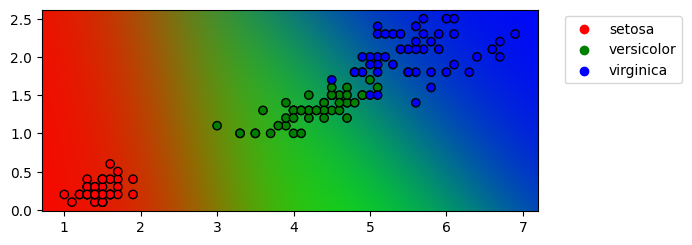

In [30]:
plot_proba_with_sklearn(get_X([2,3]))

Test du Multidim avec intercept pour les colonnes 1 et 3 avec sklearn

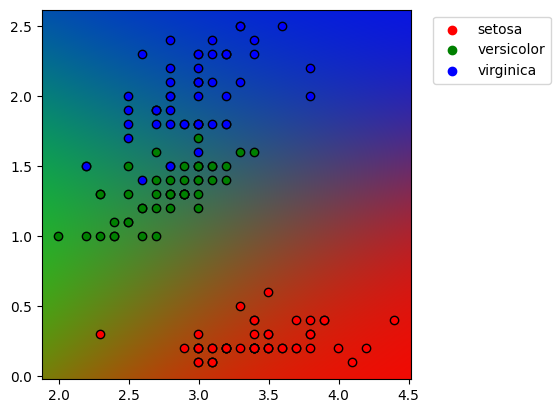

In [31]:
plot_proba_with_sklearn(get_X([1,3]))

#### 1.2 Jeu de données médical

In [32]:
df = pd.read_csv('https://tinyurl.com/y2rbbfxz')

df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [33]:
df.drop('time', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.1 KB


In [34]:
#1)
categoric_vars = [col for col in df.columns if np.isin(df[col].unique(), [0,1]).all()]
numeric_vars = [col for col in df.columns if np.isin(df[col].unique(), [0,1], invert=True).any()]
print('categories: ', categoric_vars)
print('variables numeriques: ', numeric_vars)

categories:  ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']
variables numeriques:  ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']


In [35]:
#2)
df[numeric_vars].describe().loc[['min','50%','max']]

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
min,40.0,23.0,14.0,25100.0,0.5,113.0
50%,60.0,250.0,38.0,262000.0,1.1,137.0
max,95.0,7861.0,80.0,850000.0,9.4,148.0


In [36]:
#3)
print(f'le jeu de donnees contient {df.shape[0]} lignes.')

le jeu de donnees contient 299 lignes.


In [37]:
#4)
from sklearn.model_selection import train_test_split
train: pd.DataFrame; test: pd.DataFrame
train, test = train_test_split(df,train_size=250)  # type: ignore
print(f'les dimensions de train sont: {train.shape} \n les dimensions de test sont : {test.shape}')

les dimensions de train sont: (250, 12) 
 les dimensions de test sont : (49, 12)


<AxesSubplot:>

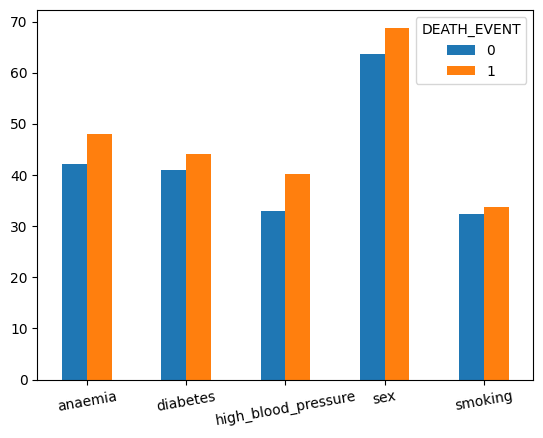

In [38]:
(train[categoric_vars].groupby('DEATH_EVENT').mean()*100).T.plot(kind='bar', rot=10)

Anaemia et high_blood_pressure semblent avoir un impact un peu plus significatif que le reste sur la survie des patients

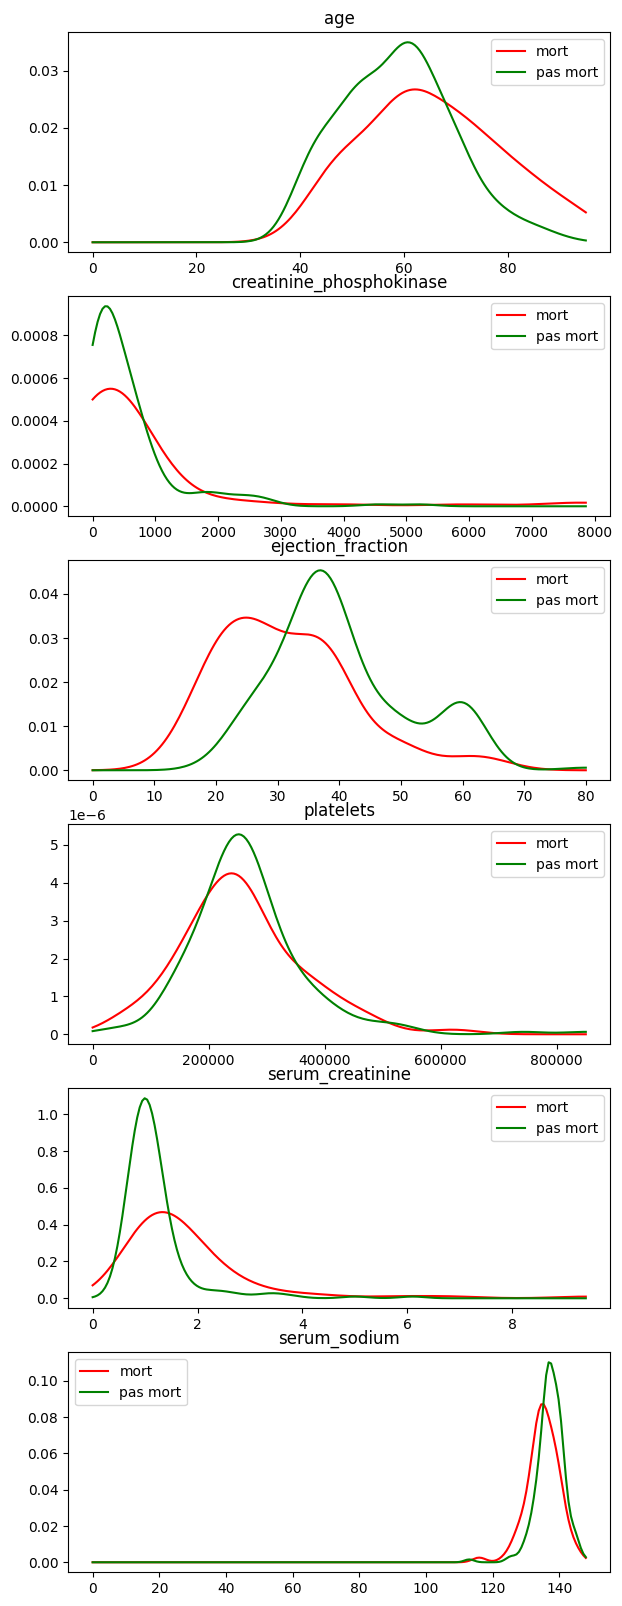

In [39]:
from scipy.stats import gaussian_kde

def plotNumericVarsDensity(numeric_vars = numeric_vars):
    fig, axes = plt.subplots(nrows=len(numeric_vars), ncols=1, figsize=(7,20))    
    axes = axes.flatten() # type: ignore
    for index, numeric in enumerate(numeric_vars):   
        x = np.linspace(0, train[numeric].max(), 200)
        axes[index].plot(x,gaussian_kde(train[numeric][train.DEATH_EVENT == 1])(x), label='mort', color='r') 
        axes[index].plot(x, gaussian_kde(train[numeric][train.DEATH_EVENT == 0])(x), label='pas mort', color='g')    
        axes[index].set_title(numeric)   
        axes[index].legend()

plotNumericVarsDensity()

##### 1.2.2 Prédiction

Pour toutes les predictions a faire avec notre propre model de Regression Logistique, on utilisera le model 'LogRegressorClassifier'
contenu dans le ficher classifier_log.py et qui regroupe
toute la partie 1.1 Regression Logistique dans une seule classe
Cette classe implemente l'interface Estimator de sklearn
et des fonctions de plotting

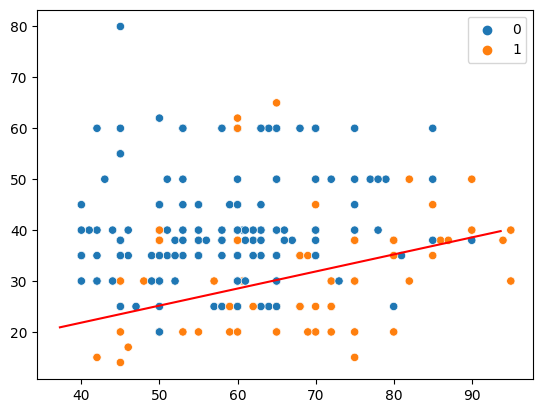

In [40]:
from classifier_log import LogRegressorClassifier
logRegressor = LogRegressorClassifier(multidim=False, intercept=True, alpha=0.001, max_iter=10000)
logRegressor.fit(train[['age', 'ejection_fraction']].to_numpy(), train['DEATH_EVENT'].to_numpy())
logRegressor.plot_binary2D()

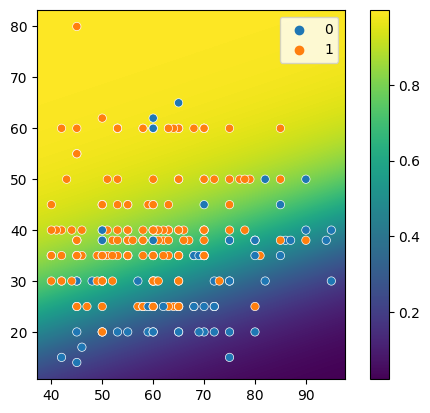

In [41]:
logRegressor.plot_proba_2D()

In [42]:
#5)
logRegressor.score_binary(test[['age', 'ejection_fraction']].to_numpy(), test['DEATH_EVENT'].to_numpy())

0.6326530612244898

On obtient une precision d'environ 0.76 (selon le split du dataset) avec les colonnes 'Age' et 'ejection_fraction'

In [43]:
logRegressorAllColumns = LogRegressorClassifier(multidim=False, intercept=True, alpha=0.001, max_iter=1000000)
logRegressorAllColumns.fit(train.drop('DEATH_EVENT',axis=1).to_numpy(), train['DEATH_EVENT'].to_numpy())
logRegressorAllColumns.score_binary(test.drop('DEATH_EVENT',axis=1).to_numpy(), test['DEATH_EVENT'].to_numpy())

c:\Users\talal\Desktop\CLIENT_PROJECTS\cours\classifier_log.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.3877551020408163

On obtient une precision de 0.65 ou de 0.35 avec toutes les colonnes (selon le split du dataset)

In [44]:
(test['DEATH_EVENT'] == 0).sum() / test['DEATH_EVENT'].shape[0]  

0.6122448979591837

La Precision du modele "Personne ne meurt" ou "Tout le monde meurt" est la meme que la regression sur toutes les colonnes.
On peut en deduire que la regression sur toutes les colonnes est nulle.
La regression sur les deux colonnes 'Age' et 'ejection_fraction' semble donner de meilleurs resultats

In [45]:
from sklearn.linear_model import LogisticRegression
sklogReg = LogisticRegression(C=1) 
sklogReg.fit(train[['age', 'ejection_fraction']], train['DEATH_EVENT'])
sklogReg.score(test[['age', 'ejection_fraction']], test['DEATH_EVENT'])

0.5714285714285714

On arrive a la meme precision en utilisant les 2 colonnes avec La regression logistique de sklearn et la notre.

In [46]:
sklogRegAllColumns = LogisticRegression(C=1) 
sklogRegAllColumns.fit(train.drop('DEATH_EVENT', axis=1), train['DEATH_EVENT'])
sklogRegAllColumns.score(test.drop('DEATH_EVENT', axis=1), test['DEATH_EVENT'])

0.5510204081632653

On obtient une meilleure precision avec sklearn qu'avec notre model pour toutes les colonnes

On va essayer de voir si on peut battre la regression avec KNN sur les 2 colonnes

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    'knn': KNeighborsClassifier(n_neighbors=3),
    'svc': SVC(C=1),
    'random forest': RandomForestClassifier(),
    'logistic regression': LogisticRegression(C=1)
}

X_train = train[['age', 'ejection_fraction']]
X_test = test[['age', 'ejection_fraction']]
y_train = train['DEATH_EVENT']
y_test = test['DEATH_EVENT']

for name,classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    print(name, ' : ', classifier.score(X_test, y_test))
    

knn  :  0.5714285714285714
svc  :  0.6122448979591837
random forest  :  0.6122448979591837
logistic regression  :  0.5714285714285714


On peut voir qu'on arrive a des performances simlilaires entre:
- les plus proches voisins
- la foret d'arbres de decision
- la regression logistique
- svc

Mais cela n'est pas tres stable selon les split du jeu de donnees
neanmoins SVC semble donner de tres bon resultats
Il se pourrait que ce soit le meilleur model s'il etait parametre correctement

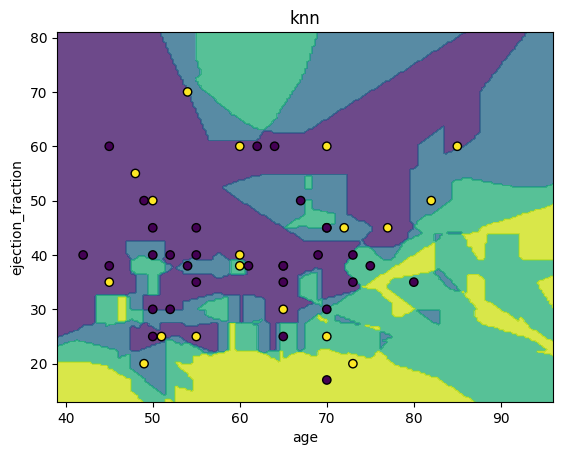

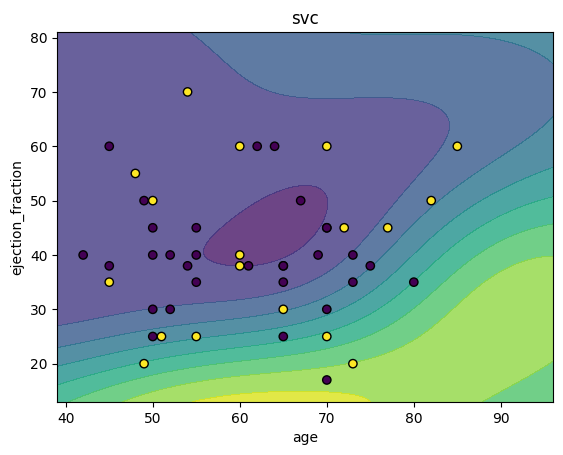

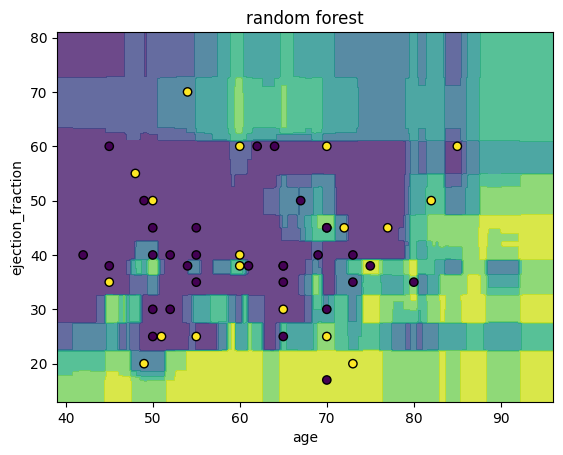

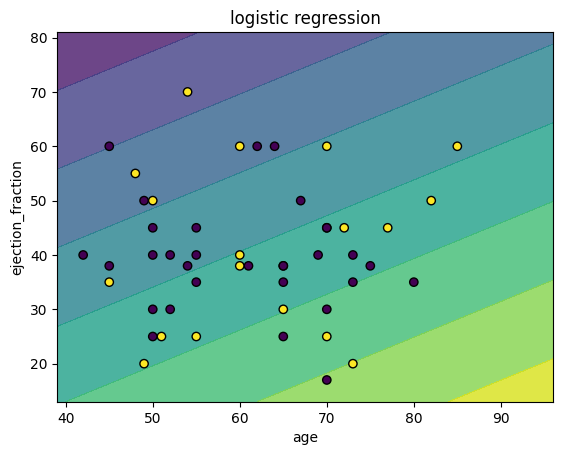

In [48]:
from sklearn.inspection import DecisionBoundaryDisplay

for name,classifier in classifiers.items():
    bounds = DecisionBoundaryDisplay.from_estimator(
        classifier,
        X_train,
        grid_resolution= 200,
        response_method="auto",
        alpha=0.8,
    )
    bounds.ax_.scatter(X_test['age'], X_test['ejection_fraction'],
                  c=y_test, edgecolor="k")
    bounds.ax_.set_title(name)
